This package implements the basic machinery for decorrelated backpropagation.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import Decorrelation, lower_triangular # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

We start by showing effective decorrelation of correlated input

iteration 0	decorrelation loss: 0.136
iteration 1	decorrelation loss: 0.135
iteration 2	decorrelation loss: 0.134
iteration 3	decorrelation loss: 0.133
iteration 4	decorrelation loss: 0.132
iteration 5	decorrelation loss: 0.131
iteration 6	decorrelation loss: 0.130
iteration 7	decorrelation loss: 0.129
iteration 8	decorrelation loss: 0.128
iteration 9	decorrelation loss: 0.127
iteration 10	decorrelation loss: 0.126
iteration 11	decorrelation loss: 0.125
iteration 12	decorrelation loss: 0.125
iteration 13	decorrelation loss: 0.124
iteration 14	decorrelation loss: 0.123
iteration 15	decorrelation loss: 0.122
iteration 16	decorrelation loss: 0.122
iteration 17	decorrelation loss: 0.121
iteration 18	decorrelation loss: 0.120
iteration 19	decorrelation loss: 0.120
iteration 20	decorrelation loss: 0.119
iteration 21	decorrelation loss: 0.118
iteration 22	decorrelation loss: 0.118
iteration 23	decorrelation loss: 0.117
iteration 24	decorrelation loss: 0.116
iteration 25	decorrelation loss: 0.

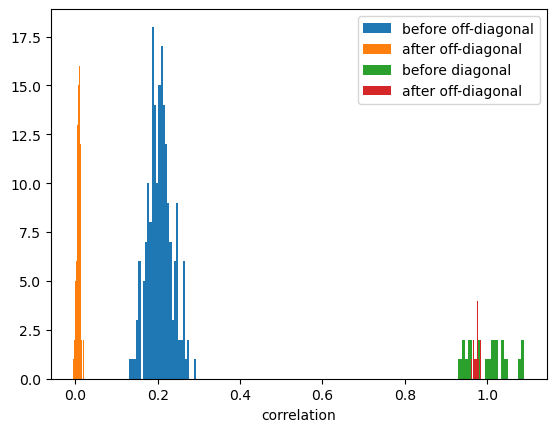

In [11]:
num_samples=1000
num_features=20

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a fully connected decorrelator
model = Decorrelation(num_features, whiten=True) # NOTE: the whitening constraint is only realised weakly due to the off-diagonal constraints; we observe a weak tendency to unit variance

# covariance matrix before training
X = model.forward(data)
A1 = (X.T @ X) / len(X)

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    loss = model.update()
    model.R -= 1e-3 * model.R.grad
    print(f'iteration {i}\tdecorrelation loss: {loss:.3f}')

# covariance matrix after training
X = model.forward(data)
A2 = (X.T @ X) / len(X)

plt.hist(lower_triangular(A1, offset=-1), bins=30, label='before off-diagonal')
plt.hist(lower_triangular(A2, offset=-1), bins=30, label='after off-diagonal')
plt.hist(torch.diag(A1), bins=A1.shape[0], label='before diagonal')
plt.hist(torch.diag(A2), bins=A2.shape[0], label='after off-diagonal')
plt.xlabel('correlation')
plt.legend();

Decorrelation of correlated input represented in convolutional [N, C, H, W] form

iteration 0; average off-diagonal kernel covariance: 0.999379
iteration 1; average off-diagonal kernel covariance: 0.258875
iteration 2; average off-diagonal kernel covariance: 0.200570
iteration 3; average off-diagonal kernel covariance: 0.165888
iteration 4; average off-diagonal kernel covariance: 0.142501
iteration 5; average off-diagonal kernel covariance: 0.125527
iteration 6; average off-diagonal kernel covariance: 0.112590
iteration 7; average off-diagonal kernel covariance: 0.102373
iteration 8; average off-diagonal kernel covariance: 0.094087
iteration 9; average off-diagonal kernel covariance: 0.087222
iteration 10; average off-diagonal kernel covariance: 0.081438
iteration 11; average off-diagonal kernel covariance: 0.076494
iteration 12; average off-diagonal kernel covariance: 0.072218
iteration 13; average off-diagonal kernel covariance: 0.068482
iteration 14; average off-diagonal kernel covariance: 0.065190
iteration 15; average off-diagonal kernel covariance: 0.062266
it

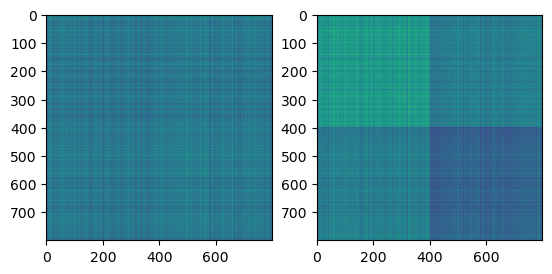

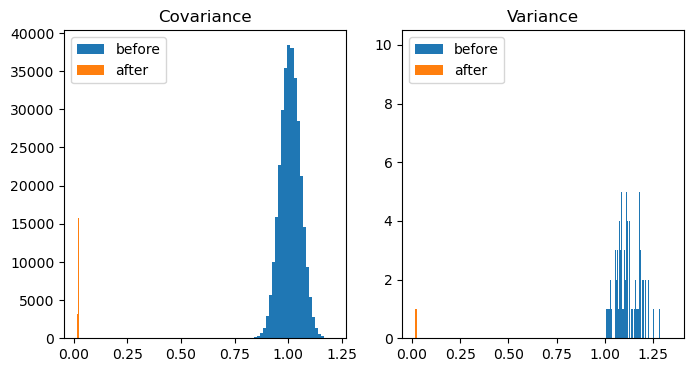

In [ ]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(5,5)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,num_channels,height,width)

# create a convolutional decorrelator
model = DecorrelationPatch2d(2, kernel_size=kernel_size, whiten=True)

# correlation matrix before training
B1 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-2 * model.R.grad
    print(f'iteration {i}; average off-diagonal kernel covariance: {covariance([model])[0].numpy():3f}')

# correlation matrix after training
B2 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

plt.subplot(1,2,1)
plt.imshow(B1)
plt.subplot(1,2,2)
plt.imshow(B2)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(lower_triangular(B1), bins=30)
plt.hist(lower_triangular(B2), bins=30)
plt.title('Covariance')
plt.legend(['before', 'after'])
plt.subplot(1,2,2)
plt.hist(torch.diag(B1), bins=B1.shape[0])
plt.hist(torch.diag(B2), bins=B2.shape[0])
plt.title('Variance')
plt.legend(['before', 'after']);

# NOTE: It is likely not the covariance but the correlations we wish to show...

In [ ]:
# MAYBE IT ALREADY WORKS? INPUT DATA SHOULD BE TRANSLATION INVARIANT? THIS IS DEFINITELY NOT THE CASE IN GENERAL... NEEDS MORE THOUGHT

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison